Import neccessary extensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
import scipy
import scipy.optimize as scpo 

Define constants and x values

In [2]:
Iterations = (10**5)
N = 7
T = N
#epsilon = T/(N)
m = 1
hbar = 1

xf = 3
xi = -3

dx = 0.05
dt = T/N
_dt = N/T

xs = np.arange(xi,dx-xi,dx)
#A = (m/(2*np.pi*dt))**(0.5*N)
#print("xs =", xs)

Functions

In [5]:
def wavefunc(x):
    return (np.exp(-0.5*x**2)/np.pi**0.25)**2

def potential(x):
    return 0.5*(x**2)

def kinetic(v):
    return 0.5*m*(v**2)

def S(path):
    E = 0
    for i in range(1,N):
        E += S_j(path,i)
    return E

def S_j(path,i):
    return dt*(kinetic((path[i]-path[i-1])*_dt) + potential(0.5*(path[i]+path[i-1])))

def metropolis(numberOfPaths,x): #iterates num times to generate optimized paths that start and end at a given x

    thermalInterval = 10

    array = np.zeros(shape=(numberOfPaths,N))
    initialPath = np.ones(N)*5
    #np.random.uniform(-3,3,N) # generate random path
    initialPath[0] = initialPath[-1] = x # set starting points to x

    #seeding algorithm
    #goal is to perform thermalizations until the path acceptance rate is between 40-60%
    #an optimised path is generated after around 20-40 sweeps based on several trials

    #ac = rj = t = 0
    #actionarray = np.zeros(100)
    for seed in range(1,41):
        perturbedPath = initialPath
        # The following loop is equivalent to one thermalization sweep
        for i in range(1,N-1):
            old = perturbedPath[i]
            a = S_j(perturbedPath,i)+S_j(perturbedPath,i+1) #Finds the change in action at x_j
            perturbedPath[i] += np.random.uniform(-1,1)
            b = S_j(perturbedPath,i)+S_j(perturbedPath,i+1)
            actiondiff = (b-a)

            if actiondiff < 0 or np.random.uniform(0,1) < np.exp(-actiondiff):
                #ac += 1
                initialPath[i] = perturbedPath[i]

            else:
                #rj += 1
                perturbedPath[i] = old

        #t+=100*ac/(ac+rj)
        #print(t/u, u)
        #ac = rj =0
        #actionarray[u-1] = S(perturbedPath)
    #print(np.std(actionarray))


    #metropolis starts here using the seeded path

    j = 0
    k = 0
    while j < numberOfPaths:

        perturbedPath = initialPath

        # The following loop is equivalent to one thermalization sweep
        for i in range(1,N-1):
            old = perturbedPath[i]
            a = S_j(perturbedPath,i)+S_j(perturbedPath,i+1) #Finds the change in action at x_j
            perturbedPath[i] += np.random.uniform(-1,1)
            b = S_j(perturbedPath,i)+S_j(perturbedPath,i+1)
            actiondiff = (b-a)

            if actiondiff < 0 or np.random.uniform(0,1) < np.exp(-actiondiff): initialPath[i] = perturbedPath[i]
            else: perturbedPath[i] = old
        
        k += 1
        if k == thermalInterval:
            array[j] = perturbedPath
            j+=1
            k = 0

    return array

def generateNRandomPaths(numberOfPaths,x):
    array = np.zeros(shape=(numberOfPaths,N))
    for j in range(0,numberOfPaths):
        initialPath = np.random.uniform(-xi,xi,N)
        initialPath[0] = initialPath[-1] = x
        array[j] = initialPath
    return array

def G(paths):#sums action of all paths
    #paths is a 2d array containing all paths
    num = len(paths)
    pathSum = 0
    for i in range(num):
        pathSum += np.exp(-S(paths[i]))
        
    return pathSum

metro = True

def Psi(num):
    array1 = np.zeros(len(xs))
    sum = 0
    for i in range(len(xs)):

        array1[i] = G(metropolis(num,xs[i])) #metropolis paths

        sum += array1[i]
        #print(xs[i])
    return array1/(sum*dx)


def path_error_analysis(paths_list, num_trials, Psi_func):
    errors = [paths_list.size]
    for i in range(paths_list):
        results = np.array([Psi_func(paths_list[i]) for _ in range(num_trials)])
        std_dev = np.std(results, axis=0)  # Standard deviation across trials
        errors[i] = std_dev/np.sqrt(num_trials)
    
    return errors

In [ ]:
paths_list = np.arange(1,5+1,1) # Number of paths to test
num_trials = 100 # Number of trials for averaging
errors = path_error_analysis(paths_list, num_trials, Psi)


TypeError: only integer scalar arrays can be converted to a scalar index

In [7]:
aa = []
bb = []

slice = 0
for i in range(len(paths_list)):
    aa.append(errors[i][slice])
    bb.append(errors[i])
print(aa)
log_paths = np.log(paths_list)
log_errors = np.log(aa)
fit = np.polyfit(log_paths, log_errors, 1)
scaling_exponent = fit[0]  # Should be approximately -0.5
C = np.exp(fit[1])
print(C,fit[0])

plt.figure()
plt.loglog(paths_list, aa, 'o-', label='Measured Errors')
plt.loglog(paths_list, C * np.array(paths_list)**fit[0], '--', label=f'Fit: Error ~ Paths^{fit[0]:.2f}')
plt.xlabel('Number of Paths')
plt.ylabel('Error')
plt.legend()
plt.title('Error Scaling with Number of Paths')
plt.show()


def heatmap2d(arr):
    plt.imshow(arr, cmap='magma')
    plt.colorbar()
    plt.title("Error dependence on X\nand number of paths for {} trials".format(num_trials))
    plt.xlabel("Position X")
    plt.ylabel("Number of Paths ")
    plt.show()

heatmap2d(bb)

NameError: name 'errors' is not defined

Generate an average set of y values and standard errors for a set number of paths

In [ ]:
def average(num_to_avs,paths1):
    l = len(xs)
    array = np.zeros((num_to_avs,l))
    ave = np.zeros(l)
    errs = np.zeros(l)
    patherrs = np.zeros(l)

    #print(array)
    for i in range(num_to_avs):
        array[i] = Psi(paths1)
        ave += array[i]
        #print(i)

    for k in range(l):
        errs[k] = np.std(array[:,k])

    averageys = ave/num_to_avs
    aveerrs = np.sqrt((errs**2/num_to_avs) + 0*(patherrs**2/paths1))

    return averageys, aveerrs

In [ ]:
a = 2
ys, yerrs = average(a,a)# average(NumberOfAverages,NumberOfPaths)



This Calculates the Chi squared values

In [ ]:
def chi_squared(model, x_data, y_data, y_err):
    return np.sum(((y_data - model(x_data))/y_err)**2)

chi_squared_min = chi_squared(wavefunc, xs, ys, yerrs)
degrees_of_freedom = (xs.size-1)
reduced_chi2 = chi_squared_min/degrees_of_freedom
Pvalue = scipy.stats.chi2.sf(chi_squared_min, degrees_of_freedom)

print('chi^2_min = {}'.format(chi_squared_min))
print("Degrees of freedom = {}".format(degrees_of_freedom))
print('reduced chi^2 = {}'.format(reduced_chi2))
print('P(chi^2_min, DoF) = {}'.format(Pvalue))
#critical value for 121 dof at 5% significance level 147.674

chi^2_min = 31869801.931062564
Degrees of freedom = 120
reduced chi^2 = 265581.6827588547
P(chi^2_min, DoF) = 0.0


In [ ]:
#plot limits
delta = 0.02
#must be a multiple of dx = 0.05 and startx < endx
startx = -3
endx = 3

startx -= delta
endx += delta
textsize = 13
plotheight = 0.8
plotwidth = 0.8
resplotheight = 0.25
histplotwidth = 0.15
miniscale = 0.35
minitextscale = 0.75
minirange = int(np.abs((startx - endx))/dx+1)
print(minirange)

startindex = 0

for i in range(len(xs)):
    if round(xs[i] - (startx+delta), 4) == 0:
        startindex = i

endindex = minirange
#print(startindex,endindex)
miny=0
if round(ys[startindex],2) > round(ys[startindex+endindex-1],2):
    miny = round(ys[startindex+endindex-1],2)
else:
    miny = round(ys[startindex],2)

minixs = (xs[startindex:])[:endindex]
miniys = (ys[startindex:])[:endindex]
miniyerrs = (yerrs[startindex:])[:endindex]


121


Plotting figures

0.198138228515595


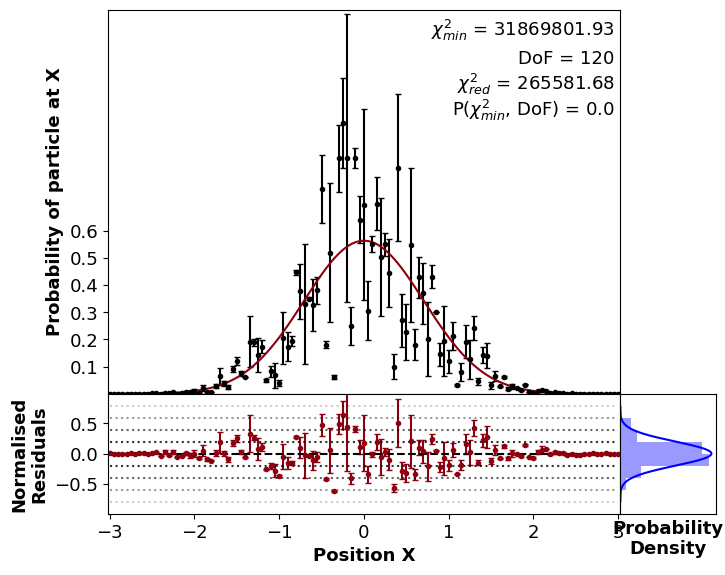

In [ ]:

f1 = plt.figure(1)


f1.add_axes((0,0,plotwidth,plotheight))
plt.gca().set_ylim([miny*0.99,np.max(ys+yerrs)*1.01])
#plt.gca().set_xlim([xs[0],xs[-1]])
plt.gca().set_xlim([startx,endx])
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([0.1,0.2,0.3,0.4,0.5,0.6])

plt.yticks(fontsize = textsize)
plt.ylabel("Probability of particle at X", fontsize = textsize, weight = "bold")

analyticalValues = wavefunc(xs)
normres = (ys-analyticalValues)/np.sqrt(analyticalValues)

reserrs = yerrs/np.sqrt(analyticalValues)

plt.errorbar(xs, ys, yerrs, linestyle = "none", fmt=".", capsize = 2, color = "black")#plot the numerical solution
plt.plot(xs,analyticalValues, color = "#8C000F")#plot the analytical solution


plt.text(.99, .98, "$\chi_{min}^2$ = "+"{}".format(str(round(chi_squared_min, 2))), ha='right', va='top', transform=plt.gca().transAxes, fontsize = textsize)#, bbox = dict(facecolor = 'red', alpha = 0.5))
plt.text(.99, .895, "DoF = {}".format(degrees_of_freedom), ha='right', va='top', transform=plt.gca().transAxes, fontsize = textsize)#, bbox = dict(facecolor = 'blue', alpha = 0.5))
plt.text(.99, .84, "$\chi_{red}^2$ = "+"{}".format(str(round(reduced_chi2, 2))), ha='right', va='top', transform=plt.gca().transAxes, fontsize = textsize)#, bbox = dict(facecolor = 'green', alpha = 0.5))
plt.text(.99, .77, "P($\chi_{min}^2$, DoF) = "+"{}".format(str(round(Pvalue, 2))), ha='right', va='top', transform=plt.gca().transAxes, fontsize = textsize)#, bbox = dict(facecolor = 'yellow', alpha = 0.5))


############################################# Mini plot showing all data

"""

f1.add_axes((0.07*plotwidth,0.07*plotheight,miniscale*plotwidth,miniscale*plotheight))
plt.gca().set_ylim([0,np.max(ys+yerrs)*1.01])
plt.gca().set_xlim([xs[0],xs[-1]])
plt.yticks(fontsize = minitextscale*textsize)
plt.xticks(fontsize = minitextscale*textsize)
plt.gca().axes.get_xaxis().set_ticks([-3,-2,-1,0,1,2,3])

plt.errorbar(minixs, miniys, miniyerrs, color = "black", linestyle = "none")#plot the numerical solution

plt.plot(xs,analyticalValues, color = "red", alpha = 0.3)#plot the analytical solution
"""



##########################################

stdd = np.std(normres)
print(stdd)

j = int(np.max(normres + reserrs)/stdd)

f1.add_axes((0,-resplotheight,plotwidth,resplotheight))#add axes for residual plot
plt.gca().set_ylim([-j*stdd,j*stdd])
plt.gca().set_xlim([startx,endx])
plt.yticks(fontsize = textsize)
plt.xticks(fontsize = textsize)


plt.ylabel("Normalised\nResiduals", fontsize = textsize, weight = "bold")
plt.xlabel("Position X", fontsize = textsize, weight = "bold")
stdresarray = np.ones(len(normres))*stdd
plt.errorbar( xs, normres, reserrs, fmt=".", color = "#8C000F", capsize=2)

for i in range(1,j):
    plt.plot(xs,i*stdresarray, color='black', linestyle='dotted', alpha = 1-i/j)

for i in range(-j+1,0):
    plt.plot(xs,i*stdresarray, color='black', linestyle='dotted', alpha = 1+i/j)

plt.plot(xs,0*stdresarray, color='black', linestyle='dashed', alpha = 1)

#######################################

x = np.arange(-j*stdd,j*stdd,0.001)
mean = statistics.mean(normres)
sd = statistics.stdev(normres)


f1.add_axes((plotwidth,-resplotheight,histplotwidth,resplotheight))#add axes for histogram plot
plt.gca().set_ylim([-j*stdd,j*stdd])
plt.gca().axes.get_yaxis().set_ticks([])
plt.gca().axes.get_xaxis().set_ticks([5,10])
plt.yticks(fontsize = textsize)
plt.xticks(fontsize = textsize)
plt.xlabel("Probability\nDensity", fontsize = textsize, weight = "bold")
histrange = np.arange(-j*stdd,(j+1)*stdd,stdd)

plt.hist(normres, histrange, density=True, orientation = "horizontal", color = "blue", alpha = 0.4)
plt.plot( norm.pdf(x, mean, sd), x, color = "blue")


#actionarray = metropolis(100,0)
#plt.plot(np.arange(0,100,1),actionarray)

plt.show()